# ANN to predict diabetes disease

### Import necessary packages

In [1]:
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.utils import resample
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn2pmml import PMMLPipeline, sklearn2pmml 

In [2]:
dataset = pd.read_csv('diabetes.csv')

In [3]:
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Plot data

In [4]:
def plot_classes(dataframe):
        plt.pie(x=[dataframe.iloc[:,-1].value_counts()[1], dataframe.iloc[:,-1].value_counts()[0]], 
                labels=["Positive", "Negative"], 
                colors=sns.color_palette("RdPu"),
                autopct='%.0f%%'
        )
        plt.show()

In [5]:
def plot_columns(dataframe):
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))

    for i in range(len(dataframe.columns)-1):
        sns.histplot(ax=axes[int(i/2), i%2], data=dataframe, x=dataframe.columns[i], hue="Outcome", kde=True, palette="RdPu")


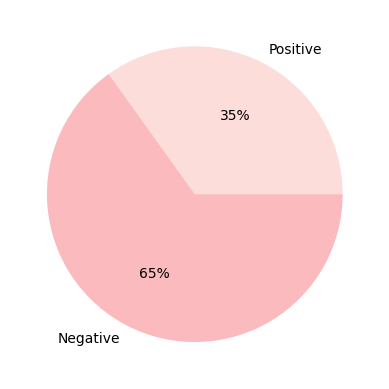

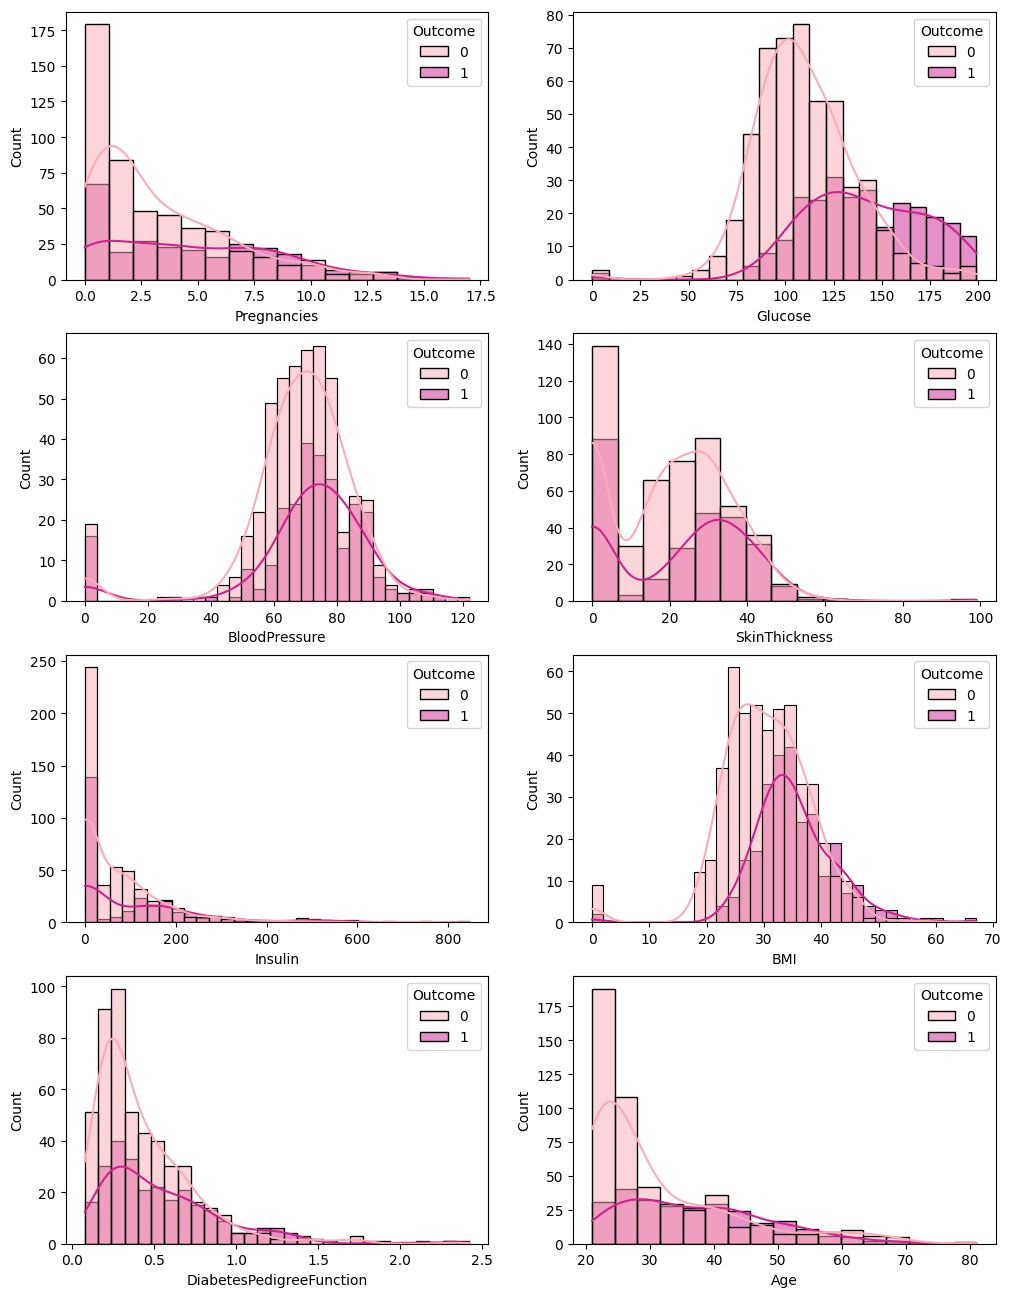

In [6]:
plot_classes(dataframe=dataset)
plot_columns(dataframe=dataset)

### Remove Outliers
Calculate for each column its Z-score for each value, relative to the column mean and standard deviation. <br>
Compare each value with absolute Z-score; no need for direction.

In [7]:
dataset = dataset[(np.abs(stats.zscore(dataset)) < 3).all(axis=1)].reset_index(drop=True)

In [8]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0


### Upsample dataset

In [9]:
positive_samples = dataset[dataset['Outcome'] == 1]
negative_samples = dataset[dataset['Outcome'] == 0]

upsampled_positives = resample(
    positive_samples,
    replace=True,
    n_samples=len(negative_samples),
    random_state=42
)
dataset = pd.concat([negative_samples, upsampled_positives])

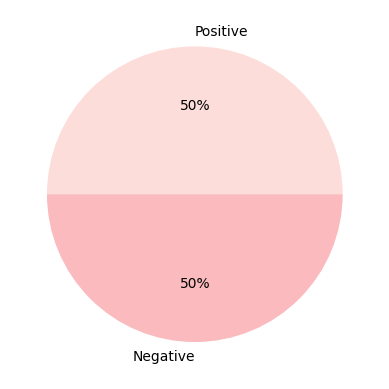

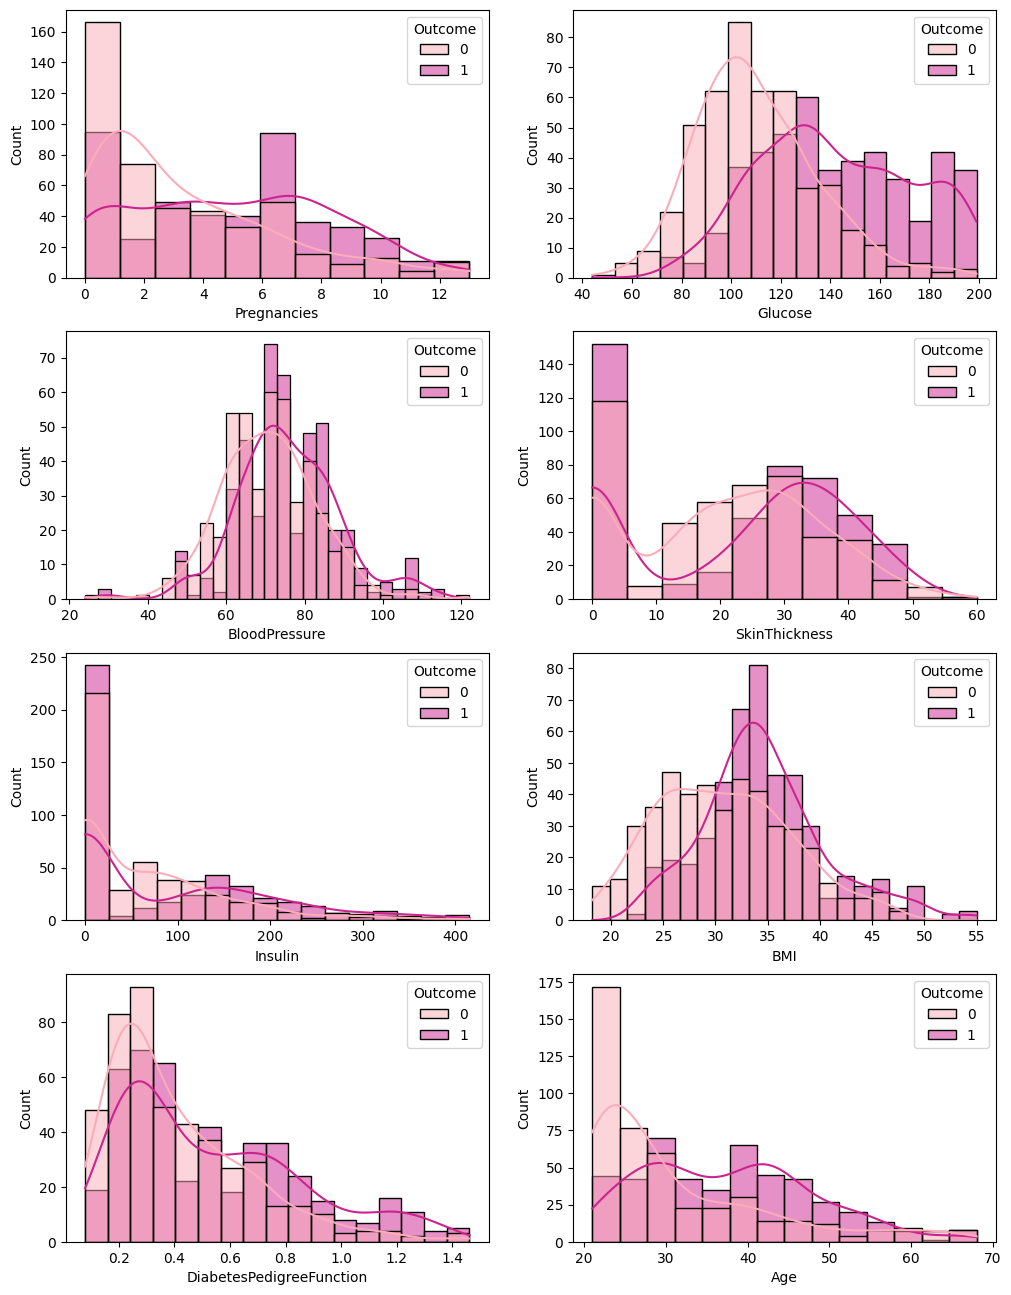

In [10]:
plot_classes(dataframe=dataset)
plot_columns(dataframe=dataset)

### Dataset seperation to **Xs**, **Ys**

In [11]:
COLUMN_NAMES = dataset.columns.tolist()[:-1]
Xs = dataset.iloc[:,:-1]
ys = dataset.iloc[:,-1]

In [12]:
Xs.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1,1,85,66,29,0,26.6,0.351,31
3,1,89,66,23,94,28.1,0.167,21
4,5,116,74,0,0,25.6,0.201,30
6,4,110,92,0,0,37.6,0.191,30
8,10,139,80,0,0,27.1,1.441,57


### Scale data based on each column's range 

In [13]:
scaler = PMMLPipeline([ ('normalizer', preprocessing.MinMaxScaler()) ])
scaler.fit(Xs)
Xs = pd.DataFrame(scaler.transform(Xs), columns=COLUMN_NAMES)

In [14]:
Xs

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.076923,0.264516,0.428571,0.483333,0.000000,0.228261,0.197397,0.212766
1,0.076923,0.290323,0.428571,0.383333,0.226506,0.269022,0.064353,0.000000
2,0.384615,0.464516,0.510204,0.000000,0.000000,0.201087,0.088937,0.191489
3,0.307692,0.425806,0.693878,0.000000,0.000000,0.527174,0.081706,0.191489
4,0.769231,0.612903,0.571429,0.000000,0.000000,0.241848,0.985539,0.765957
...,...,...,...,...,...,...,...,...
917,0.230769,0.767742,0.469388,0.300000,0.253012,0.364130,0.137383,0.148936
918,0.307692,0.329032,0.408163,0.000000,0.000000,0.375000,0.060014,0.212766
919,0.076923,0.664516,0.714286,0.683333,0.000000,0.845109,0.202458,0.127660
920,0.307692,0.432258,0.489796,0.783333,0.498795,0.513587,0.948662,0.744681


### Dataset seperation

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, train_size = 0.8, random_state = 10)

In [16]:
print(f'Size of training data= {X_train.shape} while size of testing data= {X_test.shape}')

Size of training data= (737, 8) while size of testing data= (185, 8)


In [17]:
from sklearn.neural_network import MLPClassifier

model = PMMLPipeline([ ('mlp', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64, 8), random_state=1, max_iter=300)) ])
model.fit(Xs, ys)

y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
confusion = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

print(accuracy)

0.9351351351351351


/Users/ntagky/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Show Confusion Matrix

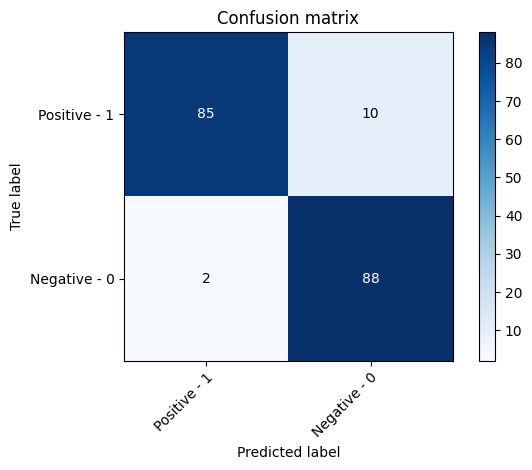

In [18]:
def plot_confusion_matrix(confusion,
                          classes,
                          normalize=False,
                          title=False,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.imshow(confusion, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(confusion.shape[1]),
           yticks=np.arange(confusion.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j, i, format(confusion[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(confusion, classes=['Positive - 1', 'Negative - 0'], title='Confusion matrix')

plt.savefig('confusionMatrix.png')
plt.show()

### Save model & normalizer

In [19]:
sklearn2pmml(model, 'model.pmml', with_repr = True)
sklearn2pmml(scaler, 'scaler.pmml', with_repr = True)